In [27]:
import croissant as cro
import matplotlib.pyplot as plt
import numpy as np

The short ($L << \lambda/2$) dipole power in the farfield for an antenna of length L goes as
$$P(\theta, \lambda) \propto \left(\frac{L}{\lambda}\right)^2 \sin^2{\theta} \iff P(\theta, \nu) \propto (L\nu)^2 \sin^2{\theta} $$

In the equation above, $\theta$ is the angle to the current. In spherical coordinates, where $\theta$ is the polar angle, the power is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In the language of [spherical harmonics](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics), the power is completely described by the $\ell=0$ and $\ell=2$ modes:
$$P(\theta, \nu) \propto (L\nu)^2 \left(\frac{3\sqrt{5}}{2}Y_0^0(\theta) + Y_2^0(\theta) \right)$$

In [28]:
def dipole_alm(frequency, ant_length):
    """
    Compute the spherical harmonics coefficients for a short dipole.
    """
    leff_sq = (ant_length * frequency) **2  # effective length
    a00 = leff_sq * 3 * np.sqrt(5) / 2
    a20 = leff_sq
    return a00, a20

In [29]:
ant_length = 1  # m, the lenght of our dipole antenna
frequencies = np.linspace(50, 100, 51)  # MHz

beam = cro.beam.Beam(lmax=12, frequencies=frequencies)

for i, freq in enumerate(beam.frequencies):
    a00, a20 = dipole_alm(freq, ant_length)
    beam.set_coeff(a00, 0, 0, freq_idx=i)
    beam.set_coeff(a20, 2, 0, freq_idx=i)

Vizualize the beam with a healpix map:

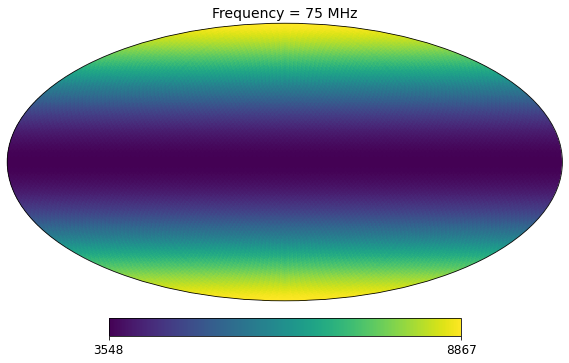

In [30]:
beam_hp = cro.healpix.HealpixMap.from_alm(beam, nside=32)
beam_hp.plot(frequency=75, cbar=True, cb_orientation="horizontal", projection_type="mollweide")

We use the Global Sky Model (Zheng et al 2016) at 75 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [31]:
sky = cro.sky.Sky.gsm([70], res="lo")
sky.power_law_map(frequencies, spectral_index=-2.5)

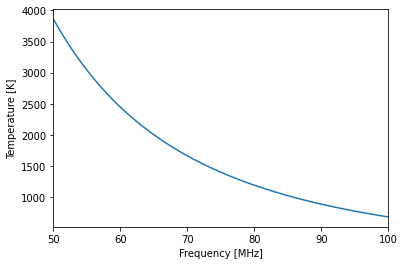

In [32]:
# the sky model is indeed a perfect power law
plt.figure()
plt.plot(frequencies, sky.data[:,0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(frequencies.min(), frequencies.max())
plt.show()

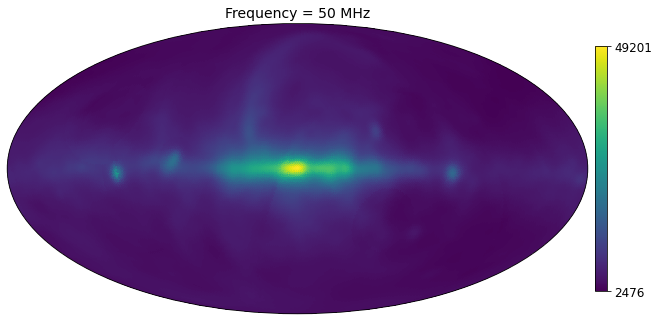

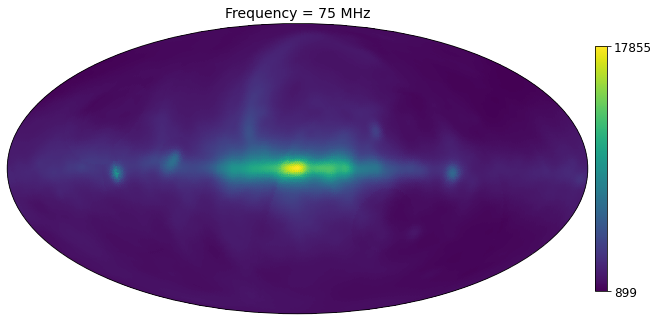

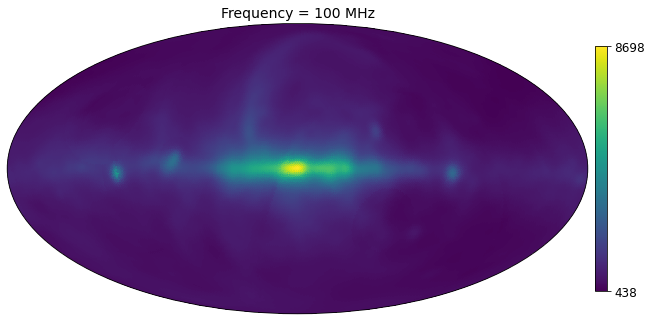

In [33]:
for freq in frequencies[::25]:
    sky.plot(frequency=freq, cbar=True, cb_orientation="vertical", projection_type="mollweide")

Run the simulator!

In [34]:
# let's do a full sidereal day = 86164.0905 seconds
times = np.linspace(0, 86164.0905, 10)
sim = cro.simulator.Simulator(beam, sky, times)
sim.run(parallel=False)

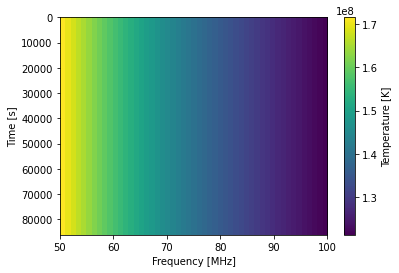

In [35]:
sim.plot()

Comment: This waterfall does not change with time. The reason is the azimuthal symmetry of the short dipole (only m=0 modes). We can add non-zero m-mode and see the change with time.

In [36]:
for i, freq in enumerate(beam.frequencies):
    a11 = (ant_length * freq)**2
    beam.set_coeff(a11, 1, 1, freq_idx=i)

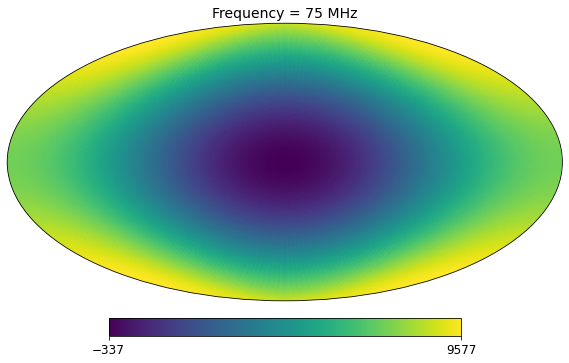

In [37]:
beam_hp = cro.healpix.HealpixMap.from_alm(beam, nside=32)
beam_hp.plot(frequency=75, cbar=True, cb_orientation="horizontal", projection_type="mollweide")

In [38]:
# since we anticpate this plot to look more interesting, we will increase the time resolution
# therefore, we use the parallel computation mode to make it run fast
times = np.linspace(0, 86164.0905, 100000)
sim = cro.simulator.Simulator(beam, sky, times)
sim.run(parallel=True, ncpu=10)

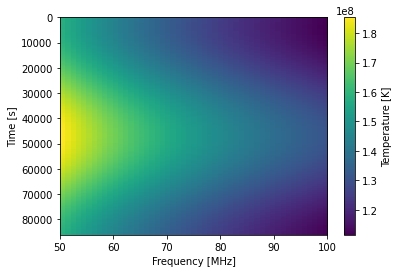

In [39]:
sim.plot()